In [2]:
import math

from tqdm.notebook import trange
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.autograd.set_detect_anomaly(True)
torch.set_default_device("cpu")
torch.manual_seed(1234)

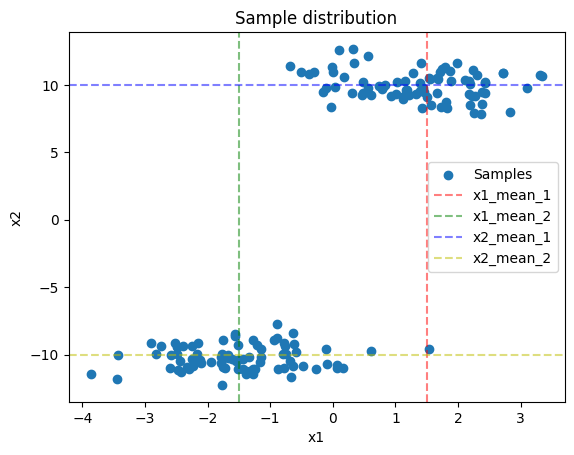

In [3]:
x1_mean_1, x1_mean_2 = 1.5, -1.5
x2_mean_1, x2_mean_2 = 10.0, -10.0
x1_std_1, x1_std_2 = 1.0, 1.0
x2_std_1, x2_std_2 = 1.0, 1.0

def generate_samples(n=100):
    n1 = n // 2
    n2 = n - n1

    x1_1 = torch.normal(mean=x1_mean_1, std=x1_std_1, size=(n1, 1))
    x2_1 = torch.normal(mean=x2_mean_1, std=x2_std_1, size=(n1, 1))

    x1_2 = torch.normal(mean=x1_mean_2, std=x1_std_2, size=(n2, 1))
    x2_2 = torch.normal(mean=x2_mean_2, std=x2_std_2, size=(n2, 1))

    x1 = torch.cat([x1_1, x1_2], dim=0)
    x2 = torch.cat([x2_1, x2_2], dim=0)

    return torch.cat([x1, x2], dim=1)

def get_grad_norm(model):
    total_norm = 0
    for param in model.parameters():
        if param.grad is not None:
            total_norm += param.grad.data.norm(2).item() ** 2
    return total_norm ** 0.5


x = generate_samples(160)

plt.figure()
plt.scatter(x[:, 0], x[:, 1], label="Samples")

plt.axvline(x1_mean_1, color='r', linestyle='--', label="x1_mean_1", alpha=0.5)
plt.axvline(x1_mean_2, color='g', linestyle='--', label="x1_mean_2", alpha=0.5)
plt.axhline(x2_mean_1, color='b', linestyle='--', label="x2_mean_1", alpha=0.5)
plt.axhline(x2_mean_2, color='y', linestyle='--', label="x2_mean_2", alpha=0.5)

plt.legend()
plt.title("Sample distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [ ]:
T = 1000
EPS = 1e-5


class TimeEmbedding(nn.Module):
    def __init__(self, embedding_dim=16):
        super(TimeEmbedding, self).__init__()
        self.linear = nn.Linear(1, embedding_dim)

    def forward(self, t):
        return torch.sin(self.linear(t))

class ScoreNet(nn.Module):
    def __init__(self, input_dims, hidden_dim=128):
        super(ScoreNet, self).__init__()
        self.embedding_dim = 16
        self.time_embedding =
        self.layers = nn.Sequential(
            # (x1, x2, t)
            nn.Linear(input_dims + self.embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            # (s1, s2)
            nn.Linear(hidden_dim, input_dims)
        )
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x, t):
        emb_t = self.time_embedding(t)
        print(emb_t.size())
        x_input = torch.cat([x, emb_t], dim=1)
        return self.layers(x_input)


def beta_schedule(T, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, T)

betas = beta_schedule(T)
alphas = 1 - betas
_alpha_bar = torch.cumprod(alphas, dim=0)

def beta(t):
    return betas[t].view(-1, 1)

def alpha_bar(t):
    return _alpha_bar[t].view(-1, 1)

def forward_diffusion(x0, t):
    noise = torch.randn_like(x0)
    xt = torch.sqrt(alpha_bar(t)) * x0 + (torch.sqrt(1 - alpha_bar(t)) + EPS) * noise
    return xt

def score_matching_loss(model, x0, xt, t):
    scores_pred = model(xt, t)
    scores_true = - (xt - torch.sqrt(alpha_bar(t)) * x0) / (1 - alpha_bar(t) + EPS)
    return torch.mean((scores_true - scores_pred) ** 2)

@torch.no_grad()
def reverse_diffusion(model, xT, T):
    model.eval()
    xt = xT
    for t in reversed(range(T)):
        t_tensor = torch.tensor([t]).repeat(xt.shape[0], 1)
        score = model(xt, t_tensor)
        xt = (
            1 / (torch.sqrt(1 - beta(t))) + EPS) \
            * (xt - (beta(t) / torch.sqrt(1 - alpha_bar(t))) \
            * score
        )

    return xt

In [ ]:
EPOCHS = 10
BATCH_SIZE = 1
LR = 1e-4
NB_BATCHES_PER_EPOCH = 10
CLIP_NORM = 1.0

grad_norms = []
batch_ids = []
losses = []
model = ScoreNet(input_dims=2, hidden_dim=64)
optimizer = optim.Adam(params=model.parameters(), lr=LR)

x0 = generate_samples(n=BATCH_SIZE * NB_BATCHES_PER_EPOCH)

dataloader = torch.utils.data.DataLoader(x0, batch_size=BATCH_SIZE, shuffle=True)

for e in trange(EPOCHS):
    for step, batch in enumerate(dataloader):
        model.train()
        optimizer.zero_grad()

        t = torch.randint(0, T, (BATCH_SIZE, 1))
        xt = forward_diffusion(batch, t)

        loss = score_matching_loss(model, batch, xt, t)
        loss.backward()

        # grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_NORM)

        if step == NB_BATCHES_PER_EPOCH - 1:
            batch_ids.append(e * step)
            losses.append(loss.item())
            grad_norms.append(get_grad_norm(model))

        optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

RuntimeError: mat1 and mat2 must have the same dtype, but got Long and Float

In [ ]:

plt.plot(batch_ids, losses)
plt.xlabel("#Batch")
plt.ylabel("MSE")
plt.yscale("log")
plt.title("Train Loss")
plt.show()

plt.figure()
plt.plot(batch_ids, grad_norms)
plt.xlabel("#Batch")
plt.ylabel("Norm")
plt.title("Gradients norm")
plt.show()